In [1]:
import numpy as np
import scipy 
from matplotlib import pyplot as plt
from sklearn.neighbors import NearestCentroid

In [23]:
def LDA_GSVD(X,y):
    clf = NearestCentroid()
    clf.fit(X, y)
    centroids = clf.centroids_
    class_centroid = X.mean(axis=0)
    N = X.shape[0]
    N_class = {}
    y  = y.astype(int)
    
    for i in range(X.shape[0]):
        if y[i] in N_class:
            N_class[y[i]]+=1
        else:
            N_class[y[i]]=1

    H_b = np.zeros((len(N_class),X.shape[1]))

    for i in range(len(N_class)):
        H_b[i] = np.sqrt(N_class[i])*(centroids[i]-class_centroid)
    
    sub_class = {}
    for idx in range(X.shape[0]):
        
        if y[idx] in sub_class:
            sub_class[y[idx]] = np.vstack((sub_class[y[idx]],X[idx]))
        else:
             sub_class[y[idx]] = np.asarray(X[idx])
    
    
    H_w = sub_class[np.unique(y)[0]] - centroids[0]
    for i in range(1,len(np.unique(y))):
        tmp_sub_class = sub_class[np.unique(y)[i]] - centroids[i]
        H_w = np.vstack((H_w, tmp_sub_class))
    
    k = len(N_class)
    K = np.concatenate((H_b, H_w))
    P, R_o, V = np.linalg.svd(K)
    #P.T K V.T = R
    R_h = np.zeros_like(R_o)
    R = R_o * (1 - np.isclose(R_h, R_o))
    R = R_o[np.nonzero(R)]
    t = R.size
    #P = P.T
    V = V.T
    P = P[:k, :t]
    R = 1/R
    R = np.diag(R)
    U, S, W = np.linalg.svd(P)
    #U.T P W.T = S
    W = W.T
    Yrw = R@W
    l = V.shape[1] - t
    hlow = np.concatenate((np.zeros((l, t)), np.eye(l)), axis=1)
    Yrw = np.concatenate((Yrw, np.zeros((t, l))), axis=1) 
    Yrw = np.concatenate((Yrw, hlow))
    G = V@Yrw
    G = G[:, :(k-1)]
    
    X_l = X@G
    
    return X_l

In [3]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression

In [4]:
from matplotlib import pyplot as plt

In [5]:
from sklearn.datasets import load_digits

X, y = load_digits(return_X_y=True)

In [6]:
X.shape

(1797, 64)

In [24]:
X_l = LDA_GSVD(X,y)
X_l.shape

(1797, 9)

In [25]:
X_l_show = X_l[:,:2]

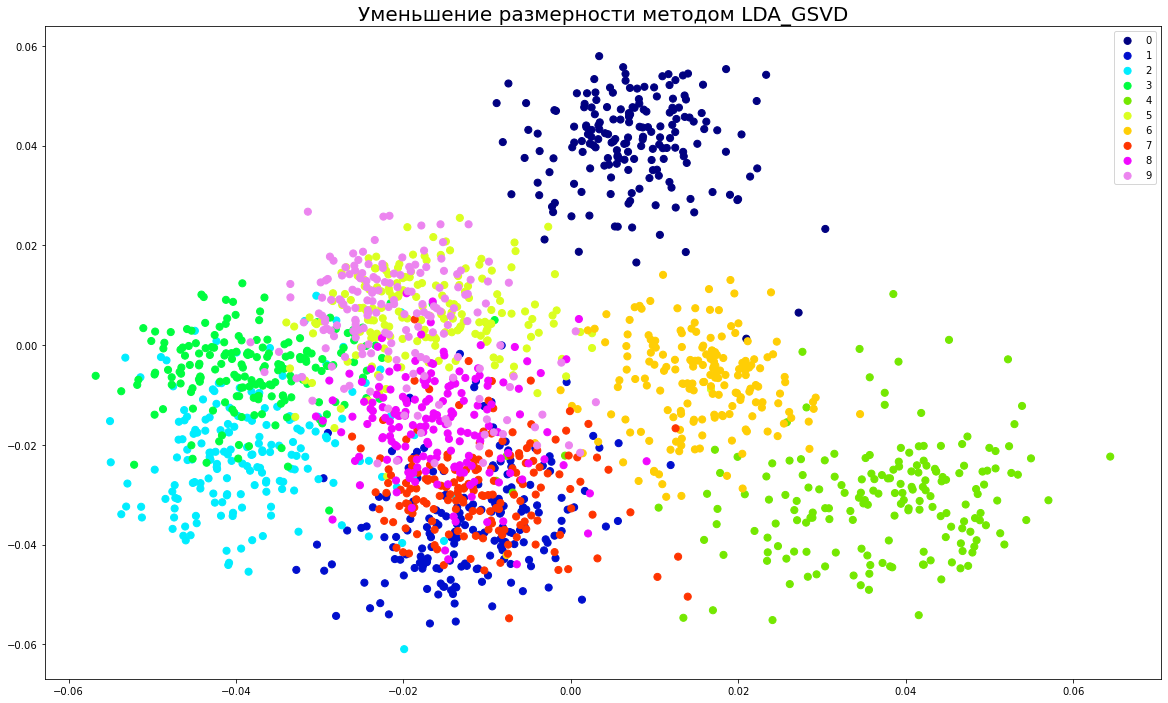

In [26]:
from matplotlib.colors import Normalize

plt.figure(figsize=(20, 12))
for d in range(10): # перебираем цифру
    norm = Normalize(vmin=0, vmax=10) # для красивых цветов
    
    
    color = plt.cm.gist_ncar(norm(d))
    plt.scatter(X_l_show[:, 0][y == d],
                X_l_show[:, 1][y == d],
                c=[color] * len(X_l_show[:, 0][y == d]), label=d, edgecolor='face', s=50)
plt.title(u"Уменьшение размерности методом LDA_GSVD", fontsize=20)
plt.legend()

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [35]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2)

In [36]:
lda_gsvd_score = []
PCA_score = []
SVD_score = []

In [37]:
for i in range(1,X_l.shape[1]+1):
    
    pca = PCA(n_components=i)
    X_pca = pca.fit(X).transform(X)
    PCA_score.append(cross_val_score(LogisticRegression(),X_pca, y, scoring='accuracy').mean())
    
    svd = TruncatedSVD(n_components=i)
    X_svd = svd.fit_transform(X)
    SVD_score.append(cross_val_score(LogisticRegression(),X_svd, y, scoring='accuracy').mean())
    
    lda_gsvd_score.append(cross_val_score(LogisticRegression(),X_l[:,:i], y, scoring='accuracy').mean())

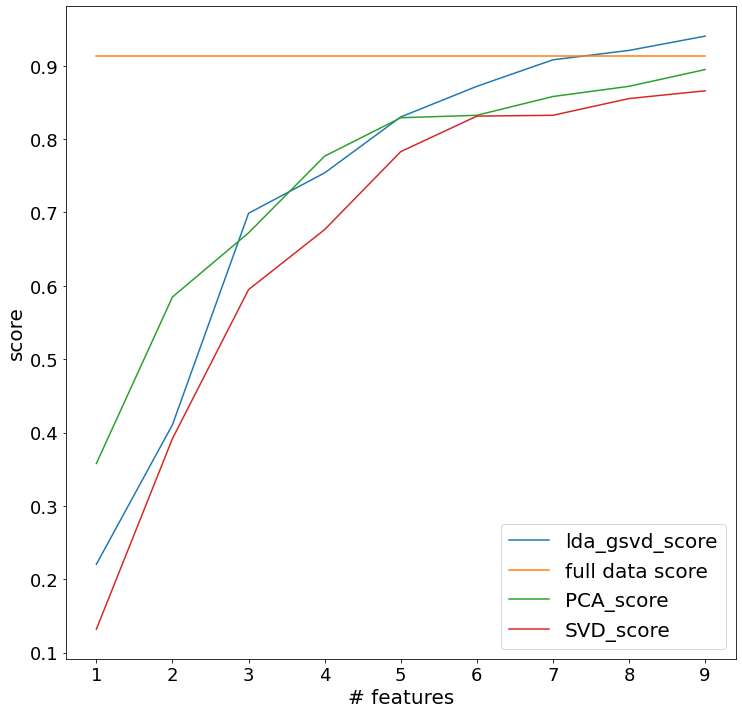

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 12))

const = cross_val_score(LogisticRegression(), X, y, scoring='accuracy').mean()
const = [const]*X_l.shape[1]

plt.plot(np.arange(1,10), lda_gsvd_score, label="lda_gsvd_score")
plt.plot(np.arange(1,10), const, label="full data score")
plt.plot(np.arange(1,10), PCA_score, label="PCA_score")
plt.plot(np.arange(1,10), SVD_score, label="SVD_score")
plt.legend(fontsize=20)
plt.xlabel("# features", fontsize=20)
plt.ylabel("score", fontsize=20)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.show()

In [40]:
lda_gsvd_score

[0.22036985453419994,
 0.4106917363045497,
 0.6989151965335809,
 0.7540173320953265,
 0.8302584339213865,
 0.8720009285051068,
 0.9081677499226247,
 0.9209702878365832,
 0.9404456824512535]

In [54]:
lda_gsvd_time = []
PCA_time = []
SVD_time = []

In [55]:
clf = LogisticRegression()
for i in range(1,X_l.shape[1]+1):
    t =  %timeit -o -q -r 1 clf.fit(X_l[:,:i], y)
    lda_gsvd_time.append(t.best)

In [56]:
for i in range(1,X_l.shape[1]+1):
    pca = PCA(n_components=i)
    X_pca = pca.fit(X).transform(X)
    
    t =  %timeit -o -q -r 1 clf.fit(X_pca, y)
    PCA_time.append(t.best)

In [57]:
for i in range(1,X_l.shape[1]+1):
    svd = TruncatedSVD(n_components=i)
    X_svd = svd.fit_transform(X)
    
    t =  %timeit -o -q -r 1 clf.fit(X_svd, y)
    SVD_time.append(t.best)

In [58]:
clf = LogisticRegression()
t =  %timeit -o -q -r 1 clf.fit(X, y)
const = [t.best]*X_l.shape[1]

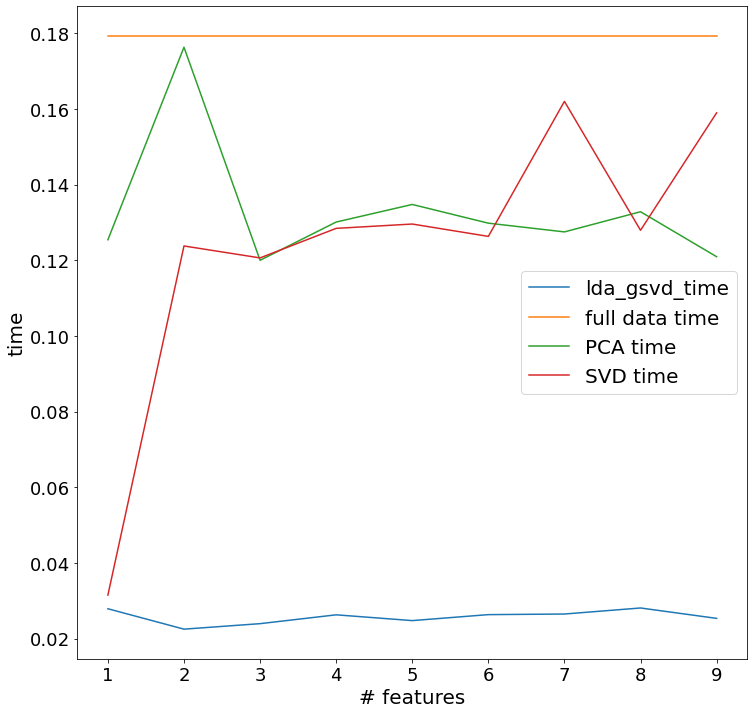

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 12))


plt.plot(np.arange(1,10), lda_gsvd_time, label="lda_gsvd_time")
plt.plot(np.arange(1,10), const, label="full data time")
plt.plot(np.arange(1,10), PCA_time, label="PCA time")
plt.plot(np.arange(1,10), SVD_time, label="SVD time")


plt.legend(fontsize=20)
plt.xlabel("# features", fontsize=20)
plt.ylabel("time", fontsize=20)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.show()

In [53]:
lda_gsvd_time

[0.027001248100032172,
 0.03359355170000526,
 0.02874996900000042,
 0.031070001999978558,
 0.032271152000021175,
 0.027982109999993555,
 0.027684607699984553,
 0.02770251599999938,
 0.026465577400040276]

In [60]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=30, resize=1.0)

X = lfw_people.data
y = lfw_people.target
names = lfw_people.target_names

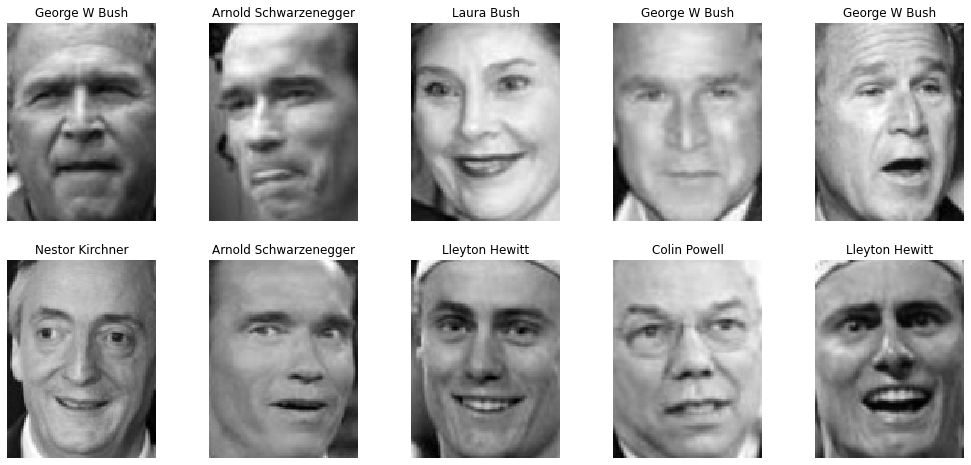

In [61]:
import matplotlib.pyplot as plt
def plot_image(image_id):
    # функция рисует изображение номер image_id
    plt.title(names[y[image_id]])
    plt.imshow(255 - lfw_people['images'][image_id], cmap=plt.cm.gray_r, interpolation='nearest')
    
def plot_grid(image_ids, nrows, ncols):
    # функция рисует изображения с id равными image_ids
    # в nrows рядов и ncols столбцов
    fig = plt.gcf()
    fig.set_size_inches(17.5, 8)
    for index, example_id in enumerate(image_ids):
        plt.subplot(nrows, ncols, index + 1)
        plot_image(example_id)
        plt.axis('off')

plot_grid(range(10), nrows=2, ncols=5)# первые 10 лиц

In [62]:
X_l = LDA_GSVD(X,y)
X_l.shape

(2370, 33)

In [63]:
rng = np.random.default_rng()
z_f = rng.choice(11750, size=100, replace=False)
z_s = rng.choice(11750, size=1000, replace=False)
z_t = rng.choice(11750, size=2300, replace=False)

In [64]:
X_f = X[:, z_f]
X_s = X[:, z_s]
X_t = X[:, z_t]

In [65]:
X_f_l = LDA_GSVD(X_f,y)
X_s_l = LDA_GSVD(X_s,y)
X_t_l = LDA_GSVD(X_t,y)
X_f_l.shape, X_s_l.shape, X_t_l.shape

((2370, 33), (2370, 33), (2370, 33))

In [66]:
X_l_show = X_l[:,:2]
X_f_l_show = X_f_l[:,:2]
X_s_l_show = X_s_l[:,:2]
X_t_l_show = X_t_l[:,:2]

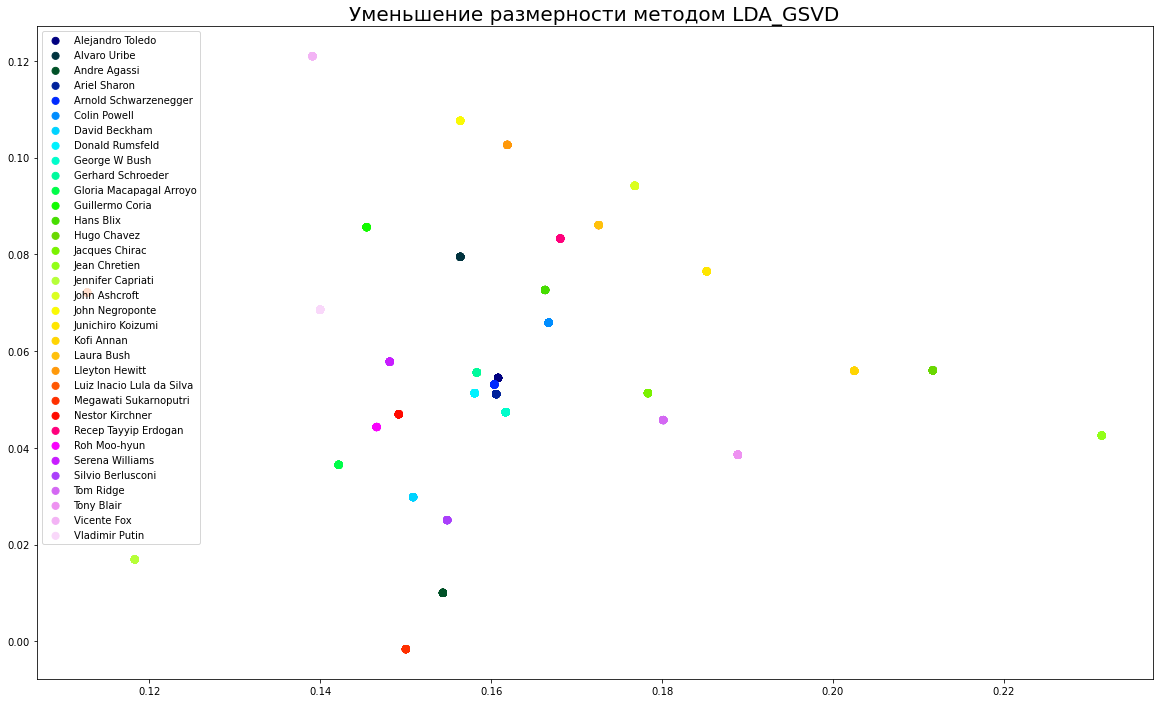

In [67]:
from matplotlib.colors import Normalize

plt.figure(figsize=(20, 12))
for d in range(34): # перебираем лица
    norm = Normalize(vmin=0, vmax=34) # для красивых цветов
    
    
    color = plt.cm.gist_ncar(norm(d))
    plt.scatter(X_l_show[:, 0][y == d],
                X_l_show[:, 1][y == d],
                c=[color] * len(X_l_show[:, 0][y == d]), label=names[d], edgecolor='face', s=50)
plt.title(u"Уменьшение размерности методом LDA_GSVD", fontsize=20)
plt.legend()

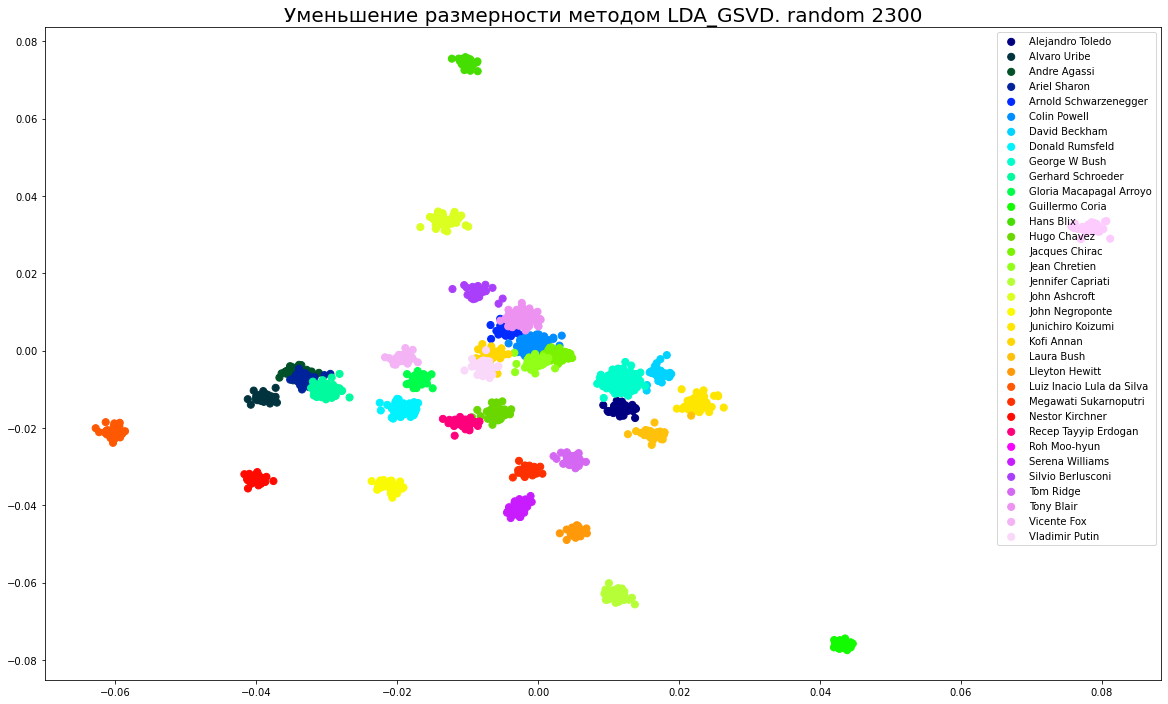

In [68]:
from matplotlib.colors import Normalize

plt.figure(figsize=(20, 12))
for d in range(34): # перебираем лица
    norm = Normalize(vmin=0, vmax=34) # для красивых цветов
    
    
    color = plt.cm.gist_ncar(norm(d))
    plt.scatter(X_t_l_show[:, 0][y == d],
                X_t_l_show[:, 1][y == d],
                c=[color] * len(X_t_l_show[:, 0][y == d]), label=names[d], edgecolor='face', s=50)
plt.title(u"Уменьшение размерности методом LDA_GSVD. random 2300", fontsize=20)
plt.legend()

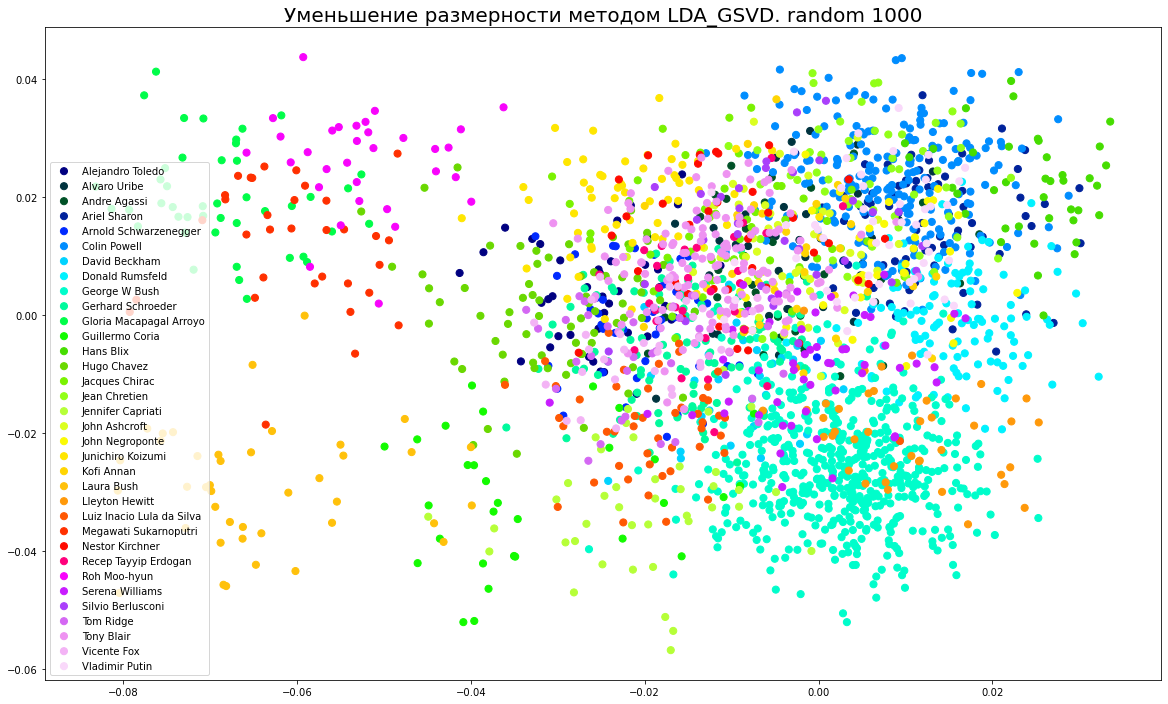

In [69]:
from matplotlib.colors import Normalize

plt.figure(figsize=(20, 12))
for d in range(34): # перебираем лица
    norm = Normalize(vmin=0, vmax=34) # для красивых цветов
    
    
    color = plt.cm.gist_ncar(norm(d))
    plt.scatter(X_s_l_show[:, 0][y == d],
                X_s_l_show[:, 1][y == d],
                c=[color] * len(X_s_l_show[:, 0][y == d]), label=names[d], edgecolor='face', s=50)
plt.title(u"Уменьшение размерности методом LDA_GSVD. random 1000", fontsize=20)
plt.legend()

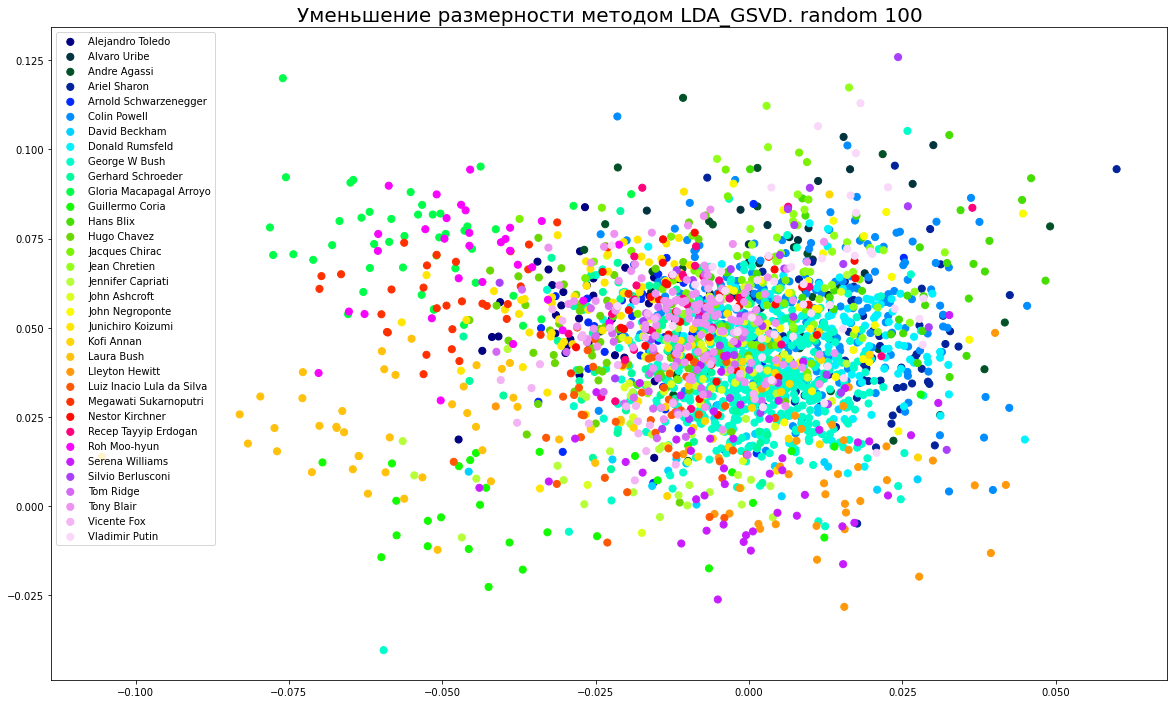

In [70]:
from matplotlib.colors import Normalize

plt.figure(figsize=(20, 12))
for d in range(34): # перебираем лица
    norm = Normalize(vmin=0, vmax=34) # для красивых цветов
    
    
    color = plt.cm.gist_ncar(norm(d))
    plt.scatter(X_f_l_show[:, 0][y == d],
                X_f_l_show[:, 1][y == d],
                c=[color] * len(X_f_l_show[:, 0][y == d]), label=names[d], edgecolor='face', s=50)
plt.title(u"Уменьшение размерности методом LDA_GSVD. random 100", fontsize=20)
plt.legend()

In [72]:
lda_gsvd_score = []
lda_gsvd_score_f = []
lda_gsvd_score_s = []
lda_gsvd_score_t = []
PCA_score = []
SVD_score = []

In [73]:
for i in range(1,X_l.shape[1]+1):
    lda_gsvd_score.append(cross_val_score(LogisticRegression(),X_l[:,:i], y, scoring='accuracy').mean())
    lda_gsvd_score_f.append(cross_val_score(LogisticRegression(),X_f_l[:,:i], y, scoring='accuracy').mean())
    lda_gsvd_score_s.append(cross_val_score(LogisticRegression(),X_s_l[:,:i], y, scoring='accuracy').mean())
    lda_gsvd_score_t.append(cross_val_score(LogisticRegression(),X_t_l[:,:i], y, scoring='accuracy').mean())
    
    pca = PCA(n_components=i)
    X_pca = pca.fit(X).transform(X)
    PCA_score.append(cross_val_score(LogisticRegression(),X_pca, y, scoring='accuracy').mean())
    
    svd = TruncatedSVD(n_components=i)
    X_svd = svd.fit_transform(X)
    SVD_score.append(cross_val_score(LogisticRegression(),X_svd, y, scoring='accuracy').mean())

In [74]:
const = cross_val_score(LogisticRegression(), X, y, scoring='accuracy').mean()
const = [const]*X_l.shape[1]

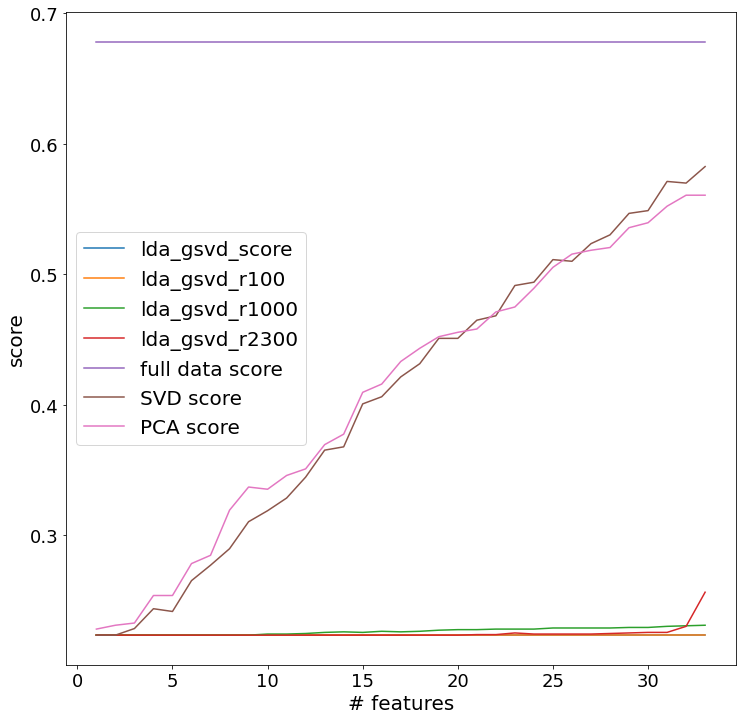

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 12))

plt.plot(np.arange(1,34), lda_gsvd_score, label="lda_gsvd_score")
plt.plot(np.arange(1,34), lda_gsvd_score_f, label="lda_gsvd_r100")
plt.plot(np.arange(1,34), lda_gsvd_score_s, label="lda_gsvd_r1000")
plt.plot(np.arange(1,34), lda_gsvd_score_t, label="lda_gsvd_r2300")
plt.plot(np.arange(1,34), const, label="full data score")
plt.plot(np.arange(1,34), SVD_score, label="SVD score")
plt.plot(np.arange(1,34), PCA_score, label="PCA score")

plt.legend(fontsize=20)
plt.xlabel("# features", fontsize=20)
plt.ylabel("score", fontsize=20)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)

plt.show()

In [78]:
lda_gsvd_time = []
lda_gsvd_time_f = []
lda_gsvd_time_s = []
lda_gsvd_time_t = []
PCA_time = []
SVD_time = []

In [79]:
clf = LogisticRegression()
for i in range(1,X_l.shape[1]+1):
    t =  %timeit -o -q -r 1 clf.fit(X_l[:,:i], y)
    lda_gsvd_time.append(t.best)

In [80]:
clf = LogisticRegression()
for i in range(1,X_l.shape[1]+1):
    t =  %timeit -o -q -r 1 clf.fit(X_f_l[:,:i], y)
    lda_gsvd_time_f.append(t.best)

In [81]:
clf = LogisticRegression()
for i in range(1,X_l.shape[1]+1):
    t =  %timeit -o -q -r 1 clf.fit(X_s_l[:,:i], y)
    lda_gsvd_time_s.append(t.best)

In [82]:
clf = LogisticRegression()
for i in range(1,X_l.shape[1]+1):
    t =  %timeit -o -q -r 1 clf.fit(X_t_l[:,:i], y)
    lda_gsvd_time_t.append(t.best)

In [83]:
clf = LogisticRegression()
t =  %timeit -o -q -r 1 clf.fit(X, y)
const = [t.best]*X_l.shape[1]

In [84]:
for i in range(1,X_l.shape[1]+1):
    pca = PCA(n_components=i)
    X_pca = pca.fit(X).transform(X)
    
    t =  %timeit -o -q -r 1 clf.fit(X_pca, y)
    PCA_time.append(t.best)

In [85]:
for i in range(1,X_l.shape[1]+1):
    svd = TruncatedSVD(n_components=i)
    X_svd = svd.fit_transform(X)
    
    t =  %timeit -o -q -r 1 clf.fit(X_svd, y)
    SVD_time.append(t.best)

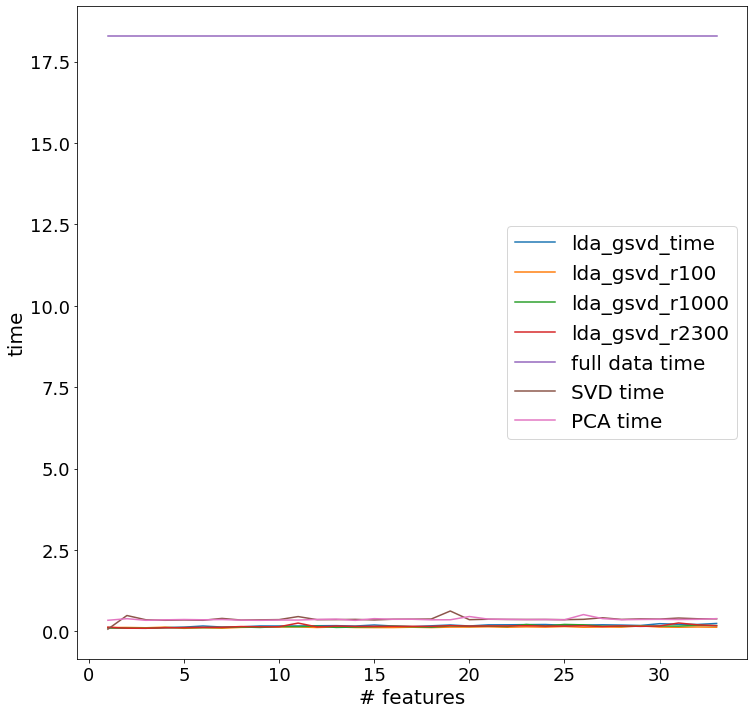

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 12))


plt.plot(np.arange(1,34), lda_gsvd_time, label="lda_gsvd_time")
plt.plot(np.arange(1,34), lda_gsvd_time_f, label="lda_gsvd_r100")
plt.plot(np.arange(1,34), lda_gsvd_time_s, label="lda_gsvd_r1000")
plt.plot(np.arange(1,34), lda_gsvd_time_t, label="lda_gsvd_r2300")
plt.plot(np.arange(1,34), const, label="full data time")
plt.plot(np.arange(1,34), SVD_time, label="SVD time")
plt.plot(np.arange(1,34), PCA_time, label="PCA time")

plt.legend(fontsize=20)
plt.xlabel("# features", fontsize=20)
plt.ylabel("time", fontsize=20)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)

plt.show()